# Experimental notebook for noise levels and EMNIST Data

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from get_emnist import (
    get_emnist_torch, 
    get_emnist_raw,
    get_emnist_from_raw_data,
    get_emnist_torch_from_raw_data
)

In [ ]:
train_images, train_labels, test_images, test_labels = get_emnist_torch_from_raw_data(
    split='letters',
    data_dir='./raw_data',
    fix_orientation=True 
)

print(f"\n✓ Loaded from raw_data directory!")
print(f"Train images: {train_images.shape}, dtype: {train_images.dtype}")
print(f"Train labels: {train_labels.shape}, dtype: {train_labels.dtype}")
print(f"Test images: {test_images.shape}")
print(f"Test labels: {test_labels.shape}")
print(f"Image value range: [{train_images.min():.3f}, {train_images.max():.3f}]")
print(f"Number of classes: {train_labels.max().item() + 1}")

letter_map = {i+1: chr(65+i) for i in range(26)}  # 1->A, 2->B, ..., 26->Z
print(f"\nLabel mapping: {dict(list(letter_map.items())[:5])} ... {dict(list(letter_map.items())[-5:])}")


Loading from raw_data directory...
  Train images: ./raw_data/downloads/extracted/ZIP.biometrics.nist.gov_cs_links_EMNIST_gzip-5u2fjN3KpzAuJXk7PNtLPNb6LcJaTw1ZM6ioBn82o4.zip/gzip/emnist-letters-train-images-idx3-ubyte.gz
  Train labels: ./raw_data/downloads/extracted/ZIP.biometrics.nist.gov_cs_links_EMNIST_gzip-5u2fjN3KpzAuJXk7PNtLPNb6LcJaTw1ZM6ioBn82o4.zip/gzip/emnist-letters-train-labels-idx1-ubyte.gz
  Test images: ./raw_data/downloads/extracted/ZIP.biometrics.nist.gov_cs_links_EMNIST_gzip-5u2fjN3KpzAuJXk7PNtLPNb6LcJaTw1ZM6ioBn82o4.zip/gzip/emnist-letters-test-images-idx3-ubyte.gz
  Test labels: ./raw_data/downloads/extracted/ZIP.biometrics.nist.gov_cs_links_EMNIST_gzip-5u2fjN3KpzAuJXk7PNtLPNb6LcJaTw1ZM6ioBn82o4.zip/gzip/emnist-letters-test-labels-idx1-ubyte.gz
Loaded: Train (124800, 28, 28), Test (20800, 28, 28)
Train: torch.Size([124800, 28, 28]), torch.Size([124800])
Test: torch.Size([20800, 28, 28]), torch.Size([20800])

✓ Loaded from raw_data directory!
Train images: torch.Size

/Users/brianrapanan/966-project/get_emnist.py:71: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  train_labels = torch.from_numpy(train_labels).long()


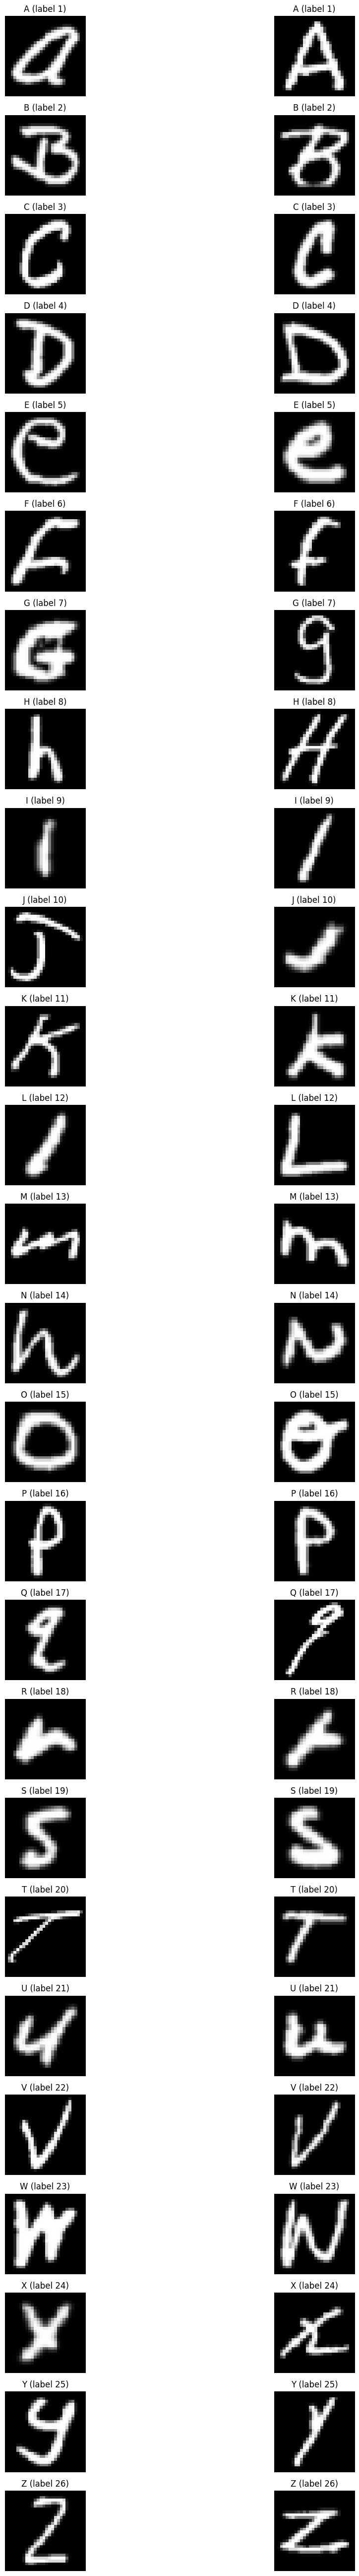

In [ ]:
def check_letter_orientation(images, labels, letter_map, samples_per_class=3):
    """Visualize samples to check if letters are properly oriented"""
    unique_labels = torch.unique(labels).numpy()
    
    fig, axes = plt.subplots(len(unique_labels), samples_per_class, figsize=(15, len(unique_labels)*2))
    if len(unique_labels) == 1:
        axes = axes.reshape(1, -1)
    
    for i, label in enumerate(unique_labels):
        label_indices = (labels == label).nonzero(as_tuple=True)[0]
        sample_indices = label_indices[:samples_per_class]
        
        for j, idx in enumerate(sample_indices):
            img = images[idx].numpy()
            axes[i, j].imshow(img, cmap='gray')
            letter = letter_map.get(label.item(), f'Label {label.item()}')
            axes[i, j].set_title(f'{letter} (label {label.item()})')
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

check_letter_orientation(train_images[:1000], train_labels[:1000], letter_map, samples_per_class=2)

In [ ]:
class EMNISTDataset(Dataset):
    """Dataset that works with loaded PyTorch tensors"""
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if len(image.shape) == 2:
            image = image.unsqueeze(0)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

train_dataset = EMNISTDataset(train_images, train_labels)
test_dataset = EMNISTDataset(test_images, test_labels)


transform = transforms.Compose([
    transforms.RandomRotation(10),  # Random rotation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    # Add more transforms as needed
])

train_dataset_augmented = EMNISTDataset(train_images, train_labels, transform=transform)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 124800
Test dataset size: 20800


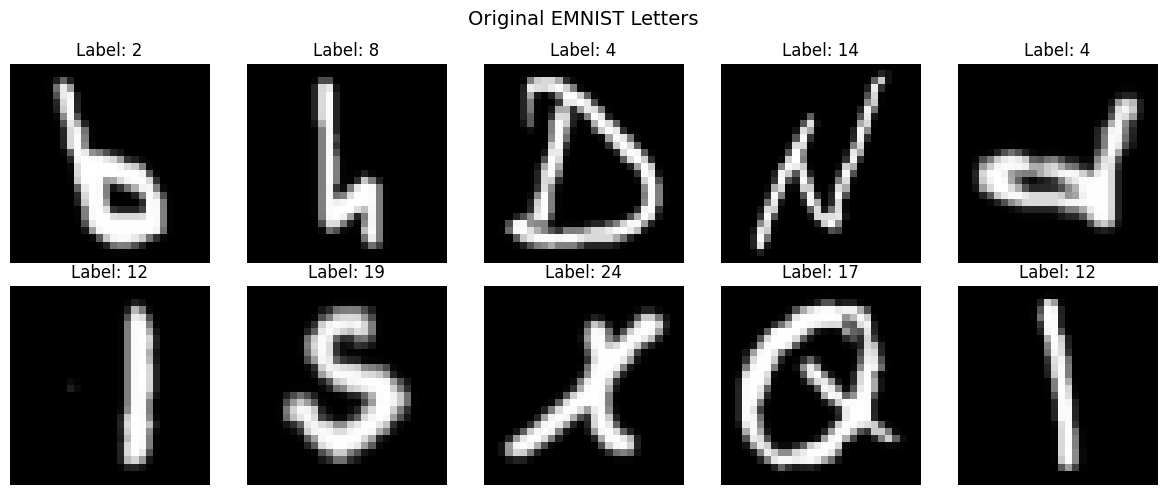

In [ ]:
def visualize_samples(dataset, num_samples=10, title="EMNIST Samples"):
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        if isinstance(image, torch.Tensor):
            img = image.squeeze().numpy()
        else:
            img = image.squeeze()
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {label.item()}')
        axes[i].axis('off')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset, num_samples=10, title="Original EMNIST Letters")


Image shape: torch.Size([28, 28])
Label: 23 (class 23)


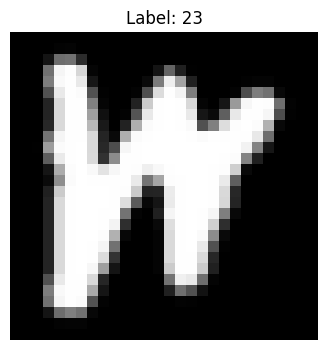


From Dataset (with channel dim): torch.Size([1, 28, 28])


In [ ]:

idx = 0
image = train_images[idx]  # Shape: (28, 28) - already normalized and orientation fixed
label = train_labels[idx]  # Shape: () - scalar tensor

print(f"Image shape: {image.shape}")
print(f"Label: {label.item()} (class {label.item()})")

plt.figure(figsize=(4, 4))
plt.imshow(image.numpy(), cmap='gray')
plt.title(f'Label: {label.item()}')
plt.axis('off')
plt.show()

image_from_dataset, label_from_dataset = train_dataset[idx]
print(f"\nFrom Dataset (with channel dim): {image_from_dataset.shape}")


In [ ]:

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")  # (batch_size, 28, 28)
    print(f"Batch labels shape: {labels.shape}")  # (batch_size,)
    print(f"First 5 labels: {labels[:5].tolist()}")
    break


Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])
First 5 labels: [26, 5, 15, 18, 23]


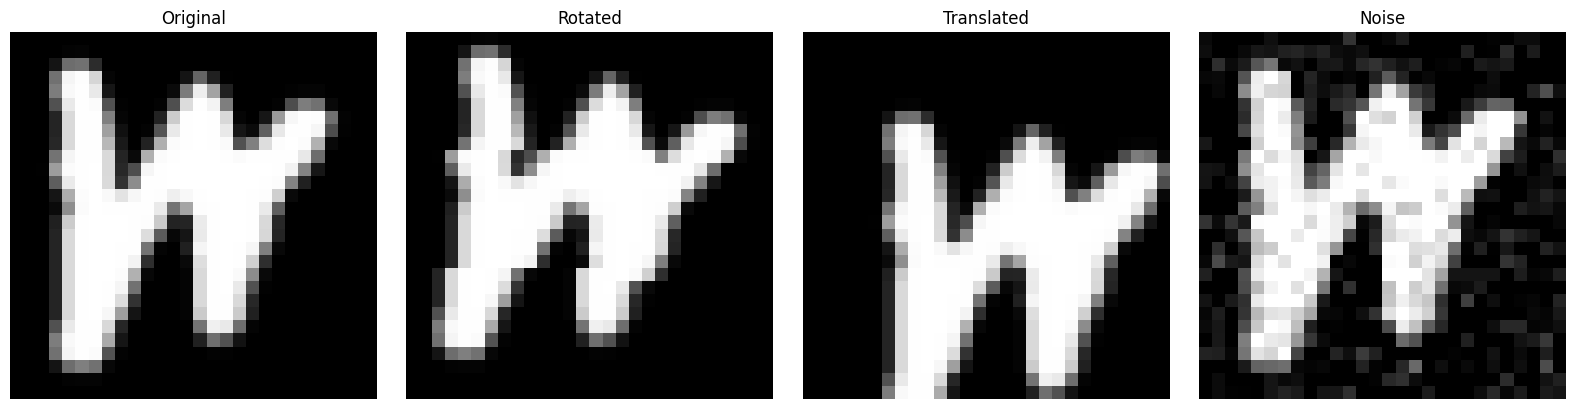

In [ ]:

transform_examples = {
    'Original': transforms.Compose([]),
    'Rotated': transforms.Compose([transforms.RandomRotation(15)]),
    'Translated': transforms.Compose([transforms.RandomAffine(degrees=0, translate=(0.2, 0.2))]),
    'Noise': transforms.Compose([
        transforms.Lambda(lambda x: torch.clamp(x + torch.randn_like(x) * 0.1, 0, 1))
    ]),
}

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
original_image = train_images[0]  # Shape: (28, 28)

if len(original_image.shape) == 2:
    original_image = original_image.unsqueeze(0)

for i, (name, transform) in enumerate(transform_examples.items()):
    transformed = transform(original_image)
    # Remove channel dimension for visualization
    img = transformed.squeeze().numpy()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


# Experiment with blur kernels

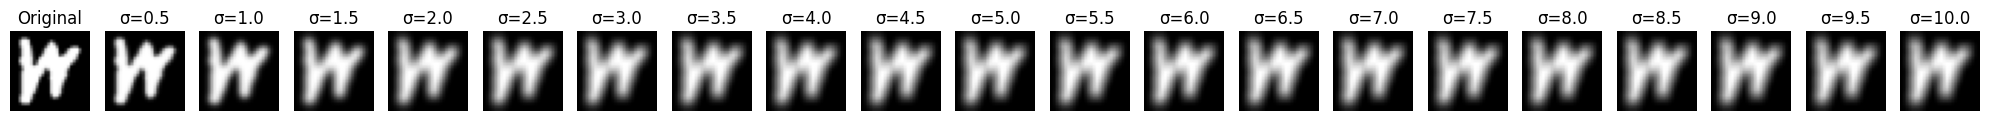

In [ ]:
sigmas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]
img = train_images[0].unsqueeze(0)  # Get first image and add channel dimension: (1, 28, 28)

plt.figure(figsize=(20, 3))

plt.subplot(1, len(sigmas) + 1, 1)
plt.imshow(img.squeeze().numpy(), cmap='gray')
plt.title('Original')
plt.axis('off')

for i, sigma in enumerate(sigmas):
    blur_kernel = transforms.GaussianBlur(kernel_size=5, sigma=sigma)
    blurred_img = blur_kernel(img)
    
    plt.subplot(1, len(sigmas) + 1, i + 2)  # i+2 because first subplot is original
    plt.imshow(blurred_img.squeeze().numpy(), cmap='gray')
    plt.title(f'σ={sigma}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Test Pixelate

In [ ]:
class Pixelate(nn.Module):
    def __init__(self, downscale_factor=4.0):
        """
        downscale_factor can be float — e.g., 2.5, 3.7, 5.2
        Larger = more pixelated.
        """
        super().__init__()
        self.downscale_factor = float(downscale_factor)

    def forward(self, img):
        """
        img: (C, H, W) float tensor
        """
        C, H, W = img.shape
        
        h_small = max(1, int(round(H / self.downscale_factor)))
        w_small = max(1, int(round(W / self.downscale_factor)))

        img_small = torch.nn.functional.interpolate(
            img.unsqueeze(0), size=(h_small, w_small), mode="nearest"
        )
        img_big = torch.nn.functional.interpolate(
            img_small, size=(H, W), mode="nearest"
        )
        return img_big.squeeze(0)



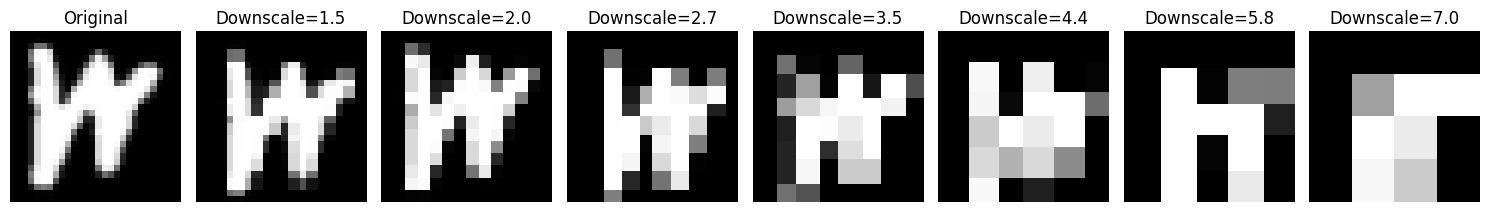

In [ ]:
downscales = [1.5, 2.0, 2.7, 3.5, 4.4, 5.8, 7.0]
img = train_images[0].unsqueeze(0)  
plt.figure(figsize=(15, 3))

plt.subplot(1, len(downscales) + 1, 1)
plt.imshow(img.squeeze().numpy(), cmap='gray')
plt.title('Original')
plt.axis('off')

for i, downscale in enumerate(downscales):
    pixelate = Pixelate(downscale)
    pixelated_img = pixelate(img)
    
    plt.subplot(1, len(downscales) + 1, i + 2)  # i+2 because first subplot is original
    plt.imshow(pixelated_img.squeeze().numpy(), cmap='gray')
    plt.title(f'Downscale={downscale}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Pixelation looks better suited for this data and experiment goal!